## 1. Environment Setup and Data Loading

Loading the preprocessed TF-IDF features and target variables from Notebook 1.

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import joblib
import os

# Scikit-learn modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load preprocessed data from Notebook 1
print("Loading preprocessed data...\n")

X_train = joblib.load('../artifacts/X_train_tfidf.joblib')
X_val = joblib.load('../artifacts/X_val_tfidf.joblib')
X_test = joblib.load('../artifacts/X_test_tfidf.joblib')

y_train = joblib.load('../artifacts/y_train.joblib')
y_val = joblib.load('../artifacts/y_val.joblib')
y_test = joblib.load('../artifacts/y_test.joblib')

tfidf_vectorizer = joblib.load('../artifacts/tfidf_vectorizer.joblib')

print("Data loaded successfully!")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nNumber of classes: {len(y_train.unique())}")
print(f"Classes: {sorted(y_train.unique())}")

Loading preprocessed data...

Data loaded successfully!
Training set: (1724, 10000)
Validation set: (370, 10000)
Test set: (370, 10000)

Number of classes: 13
Classes: ['Cardiovascular / Pulmonary', 'ENT - Otolaryngology', 'Gastroenterology', 'Hematology - Oncology', 'Nephrology', 'Neurology', 'Neurosurgery', 'Obstetrics / Gynecology', 'Ophthalmology', 'Orthopedic', 'Pediatrics - Neonatal', 'Psychiatry / Psychology', 'Radiology']


## 2. Baseline Softmax Regression Model

Training a baseline Multinomial Logistic Regression model.

In [3]:
# Initialize baseline Softmax Regression model
baseline_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Training baseline model...")
baseline_model.fit(X_train, y_train)
print("Baseline model training complete!")

Training baseline model...
Baseline model training complete!


## 3. Baseline Model Evaluation

In [4]:
# Make predictions on validation set
y_val_pred = baseline_model.predict(X_val)

# Calculate baseline metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')

print("Baseline Model Performance (Validation Set):")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Macro F1-Score: {val_f1_macro:.4f}")

Baseline Model Performance (Validation Set):
Accuracy: 0.7432
Macro F1-Score: 0.6294


## 4. Cross-Validation

Cross-Validation Results:
Mean Accuracy: 0.7477 (+/- 0.0246)


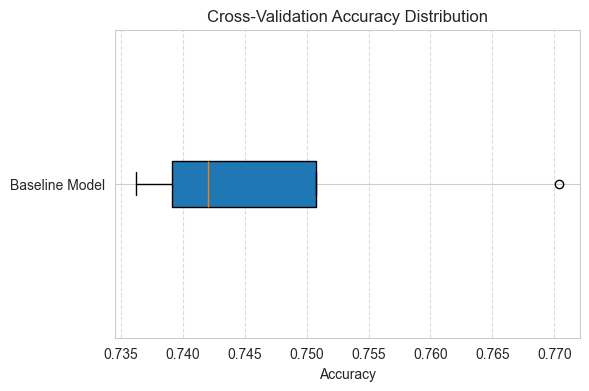

In [18]:
# Perform 5-fold stratified cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores = cross_val_score(
    baseline_model, X_train, y_train,
    cv=cv_strategy, scoring='accuracy', n_jobs=-1
)

print("Cross-Validation Results:")
print(f"Mean Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

plt.figure(figsize=(6, 4))
plt.boxplot(cv_scores, vert=False, patch_artist=True)
plt.title("Cross-Validation Accuracy Distribution")
plt.xlabel("Accuracy")
plt.yticks([1], ["Baseline Model"])
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

## 5. Hyperparameter Tuning

In [6]:
# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['lbfgs', 'saga'],
    'class_weight': [None, 'balanced']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1-score: {grid_search.best_score_:.4f}")

Starting Grid Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/kmgdk/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/kmgdk/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/kmgdk/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/kmgdk/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/kmgdk/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/kmgdk/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Con

Best parameters: {'C': 100.0, 'class_weight': 'balanced', 'solver': 'lbfgs'}
Best F1-score: 0.7501


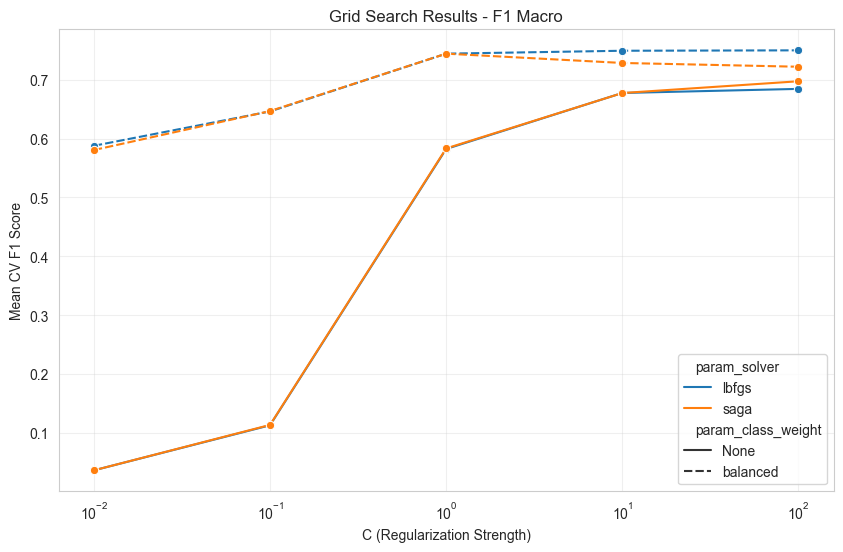

In [ ]:
# Convert cv_results_ to DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Keep only relevant columns
plot_data = results[['param_C', 'param_solver', 'param_class_weight', 'mean_test_score']]

# Convert params to string for plotting
plot_data['param_solver'] = plot_data['param_solver'].astype(str)
plot_data['param_class_weight'] = plot_data['param_class_weight'].astype(str)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=plot_data,
    x="param_C", y="mean_test_score",
    hue="param_solver", style="param_class_weight",
    marker="o"
)
plt.xscale("log")  # since C values are on log scale
plt.title("Grid Search Results - F1 Macro")
plt.xlabel("C (Regularization Strength)")
plt.ylabel("Mean CV F1 Score")
plt.grid(alpha=0.3)
plt.show()


## 6. Final Model Training

In [7]:
# Extract the best model
final_model = grid_search.best_estimator_

print("Final Model Configuration:")
print(f"C: {final_model.C}")
print(f"Solver: {final_model.solver}")
print(f"Class weight: {final_model.class_weight}")

Final Model Configuration:
C: 100.0
Solver: lbfgs
Class weight: balanced


## 7. Comprehensive Model Evaluation

In [8]:
# Make predictions on validation set
y_val_pred_final = final_model.predict(X_val)

# Calculate metrics
val_accuracy_final = accuracy_score(y_val, y_val_pred_final)
val_precision_macro = precision_score(y_val, y_val_pred_final, average='macro')
val_recall_macro = recall_score(y_val, y_val_pred_final, average='macro')
val_f1_macro = f1_score(y_val, y_val_pred_final, average='macro')
val_f1_weighted = f1_score(y_val, y_val_pred_final, average='weighted')

print("Final Model Performance (Validation Set):")
print(f"Accuracy: {val_accuracy_final:.4f}")
print(f"Precision (Macro): {val_precision_macro:.4f}")
print(f"Recall (Macro): {val_recall_macro:.4f}")
print(f"F1-Score (Macro): {val_f1_macro:.4f}")
print(f"F1-Score (Weighted): {val_f1_weighted:.4f}")

Final Model Performance (Validation Set):
Accuracy: 0.7892
Precision (Macro): 0.7531
Recall (Macro): 0.7511
F1-Score (Macro): 0.7426
F1-Score (Weighted): 0.7908


In [9]:
# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_val, y_val_pred_final, digits=4))


Detailed Classification Report:
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary     0.9174    0.9346    0.9259       107
      ENT - Otolaryngology     0.8889    0.6154    0.7273        13
          Gastroenterology     0.8846    0.7931    0.8364        29
     Hematology - Oncology     0.6842    0.6842    0.6842        19
                Nephrology     0.9167    0.6875    0.7857        16
                 Neurology     0.6667    0.5417    0.5977        48
              Neurosurgery     0.3333    0.4615    0.3871        13
   Obstetrics / Gynecology     0.9231    1.0000    0.9600        24
             Ophthalmology     1.0000    0.9000    0.9474        10
                Orthopedic     0.7656    0.7903    0.7778        62
     Pediatrics - Neonatal     0.6250    1.0000    0.7692        10
   Psychiatry / Psychology     0.8000    0.8000    0.8000        10
                 Radiology     0.3846    0.5556    0.4545         9

             

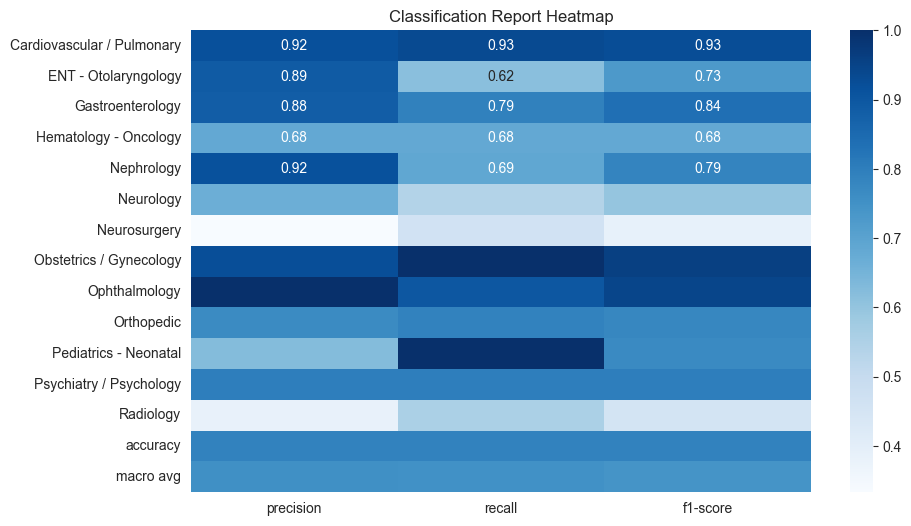

In [20]:
# Generate report as dictionary
report = classification_report(y_val, y_val_pred_final, output_dict=True)

# Convert to DataFrame
df_report = pd.DataFrame(report).transpose()

# Plot heatmap of precision/recall/F1
plt.figure(figsize=(10,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()


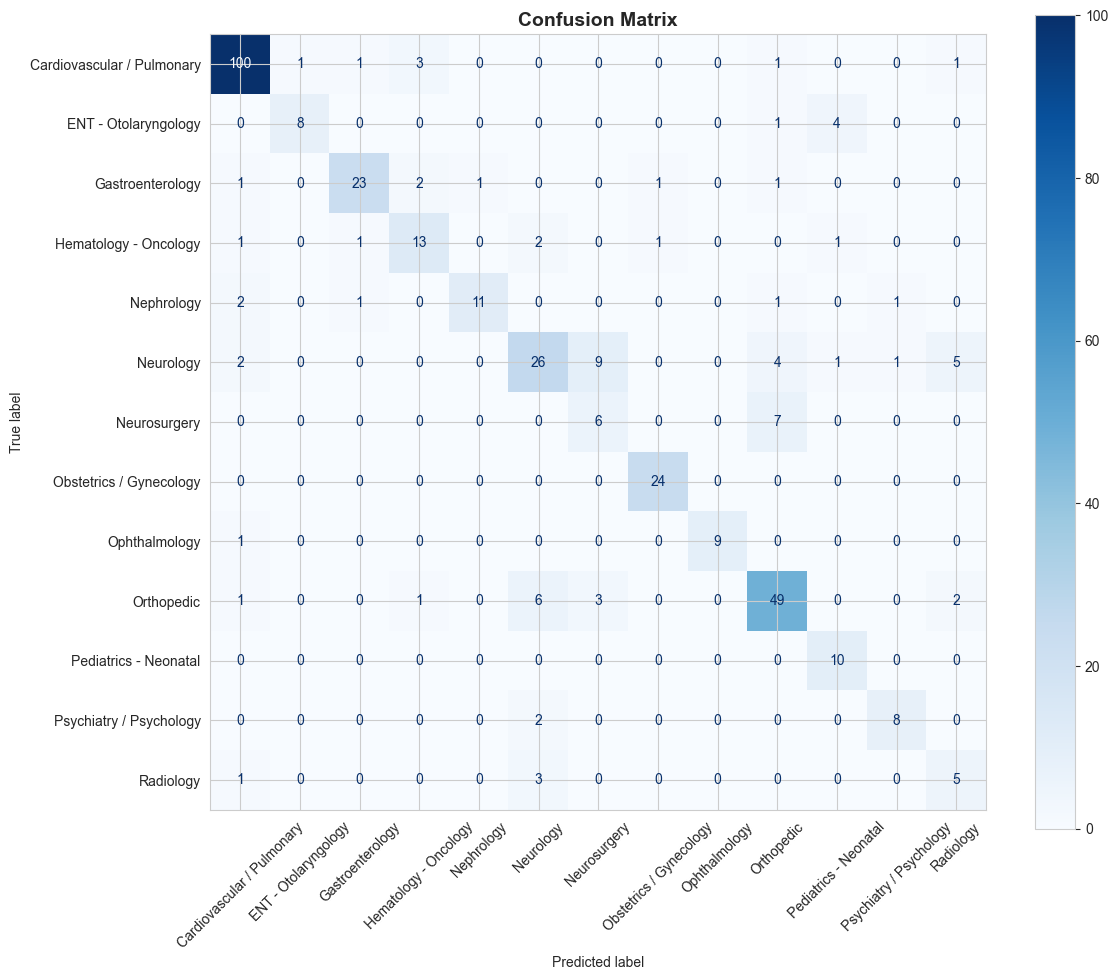

In [10]:
# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred_final)
class_names = sorted(y_val.unique())

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation=45)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Test Set Evaluation

In [11]:
# Make predictions on test set
y_test_pred = final_model.predict(X_test)

# Calculate test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')

print("Final Model Performance (Test Set):")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Macro F1-Score: {test_f1_macro:.4f}")

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

Final Model Performance (Test Set):
Accuracy: 0.7757
Macro F1-Score: 0.6768

Test Set Classification Report:
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary     0.9439    0.9266    0.9352       109
      ENT - Otolaryngology     0.7143    0.7143    0.7143        14
          Gastroenterology     0.9231    0.8780    0.9000        41
     Hematology - Oncology     0.5714    0.8000    0.6667        15
                Nephrology     1.0000    0.6000    0.7500        10
                 Neurology     0.6444    0.6170    0.6304        47
              Neurosurgery     0.4400    0.5500    0.4889        20
   Obstetrics / Gynecology     0.9600    0.7500    0.8421        32
             Ophthalmology     0.8182    0.8182    0.8182        11
                Orthopedic     0.7800    0.6842    0.7290        57
     Pediatrics - Neonatal     0.3750    1.0000    0.5455         3
   Psychiatry / Psychology     0.7778    0.7778    0.7778         9
      

## 9. Creating Production Pipeline

In [12]:
# Build the production pipeline
production_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', final_model)
])

print("Production Pipeline Created")
print(production_pipeline)

Production Pipeline Created
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=10000, min_df=2,
                                 ngram_range=(1, 3), stop_words='english',
                                 strip_accents='unicode', sublinear_tf=True,
                                 token_pattern='\\b[a-zA-Z]{3,}\\b')),
                ('classifier',
                 LogisticRegression(C=100.0, class_weight='balanced',
                                    max_iter=1000, multi_class='multinomial',
                                    n_jobs=-1, random_state=42))])


In [13]:
# Test the pipeline
from datasets import load_dataset

dataset = load_dataset('hpe-ai/medical-cases-classification-tutorial')
test_sample = dataset['test'][0]

sample_text = test_sample['transcription']
true_specialty = test_sample['medical_specialty']

predicted_specialty = production_pipeline.predict([sample_text])[0]
prediction_proba = production_pipeline.predict_proba([sample_text])[0]

print("Pipeline Test:")
print(f"True: {true_specialty}")
print(f"Predicted: {predicted_specialty}")
print(f"Confidence: {prediction_proba.max():.4f}")

Repo card metadata block was not found. Setting CardData to empty.


Pipeline Test:
True: Orthopedic
Predicted: Neurosurgery
Confidence: 0.9768


## 10. Saving the Production Pipeline

In [14]:
# Save the pipeline
pipeline_path = '../artifacts/model.joblib'
joblib.dump(production_pipeline, pipeline_path)

print(f"Pipeline saved to: {pipeline_path}")
print(f"File size: {os.path.getsize(pipeline_path) / (1024*1024):.2f} MB")

Pipeline saved to: ../artifacts/model.joblib
File size: 11.51 MB


In [15]:
# Create requirements.txt
requirements_content = """scikit-learn==1.3.0
numpy==1.24.3
pandas==2.0.3
joblib==1.3.1
"""

requirements_path = '../artifacts/requirements.txt'
with open(requirements_path, 'w') as f:
    f.write(requirements_content)

print(f"Requirements saved to: {requirements_path}")

Requirements saved to: ../artifacts/requirements.txt


## 11. Model Interpretation

In [16]:
# Extract feature importance
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = final_model.coef_
class_names_model = final_model.classes_

print("Top Predictive Features by Medical Specialty:")
n_top = 10

for idx, specialty in enumerate(class_names_model[:5]):
    print(f"\n{specialty.upper()}:")
    class_coef = coefficients[idx]
    top_idx = class_coef.argsort()[-n_top:][::-1]
    for i, feat_idx in enumerate(top_idx, 1):
        print(f"  {i}. {feature_names[feat_idx]}: {class_coef[feat_idx]:.4f}")

Top Predictive Features by Medical Specialty:

CARDIOVASCULAR / PULMONARY:
  1. chest: 5.5482
  2. pulmonary: 3.7073
  3. coronary: 3.4038
  4. cardiac: 3.3986
  5. atrial: 3.3077
  6. stress: 2.9202
  7. breath: 2.9191
  8. lung: 2.9101
  9. artery: 2.8766
  10. indications: 2.8427

ENT - OTOLARYNGOLOGY:
  1. ear: 7.4470
  2. nasal: 6.0911
  3. tube: 3.9114
  4. eardrum: 3.4314
  5. tonsil: 3.2479
  6. tonsils: 2.9621
  7. cartilage: 2.8129
  8. adenoid: 2.7372
  9. eustachian: 2.6850
  10. right ear: 2.6108

GASTROENTEROLOGY:
  1. abdominal: 5.0456
  2. stomach: 4.4963
  3. hernia: 4.0978
  4. colonoscopy: 4.0223
  5. liver: 3.6100
  6. rectal: 3.6006
  7. esophagus: 3.5536
  8. cystic: 3.4495
  9. duct: 3.3747
  10. colon: 3.3349

HEMATOLOGY - ONCOLOGY:
  1. biopsy: 4.5563
  2. cancer: 4.4884
  3. radiation: 3.4973
  4. carcinoma: 3.1902
  5. cell: 3.1268
  6. excision: 3.0290
  7. treatment: 2.9952
  8. lymphoma: 2.8872
  9. cell lymphoma: 2.7349
  10. mesothelioma: 2.7083

NEPHROL

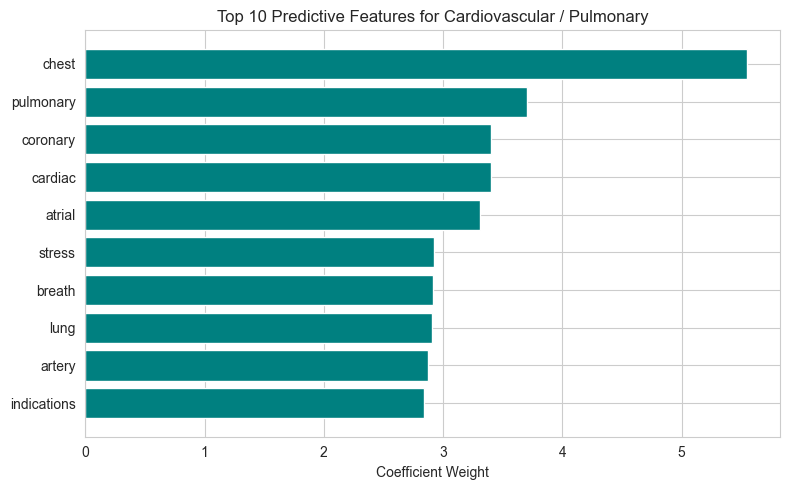

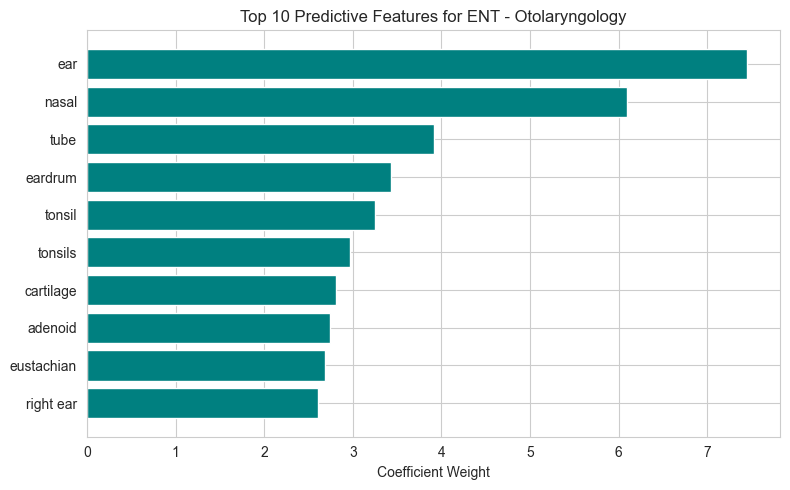

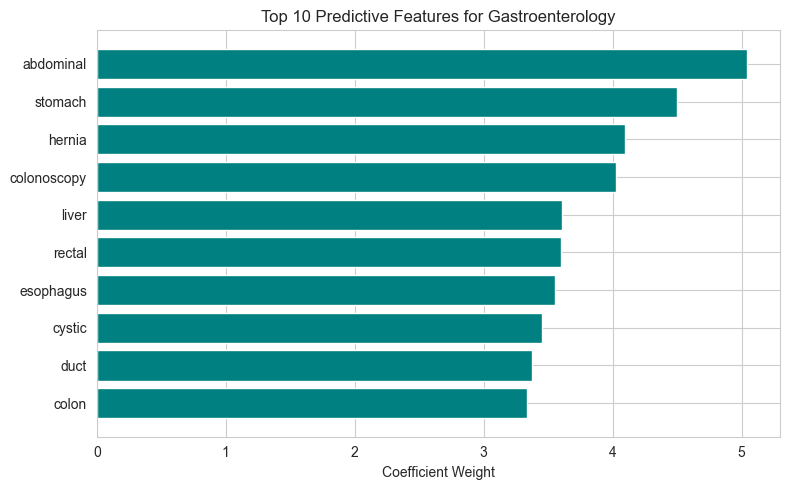

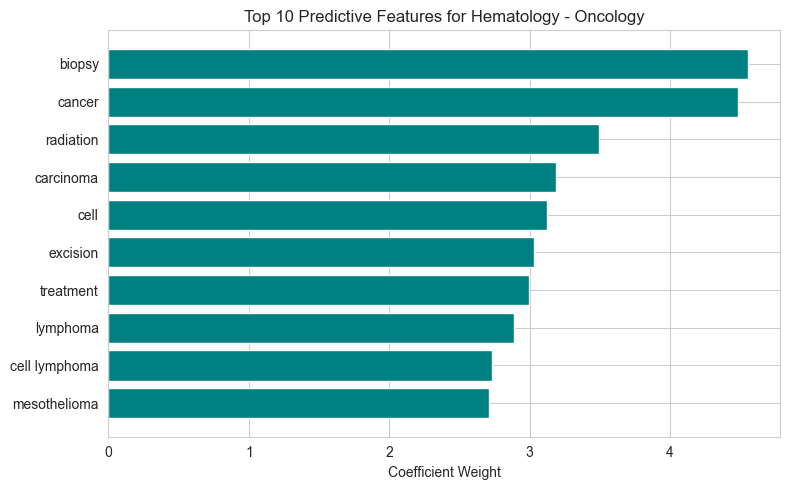

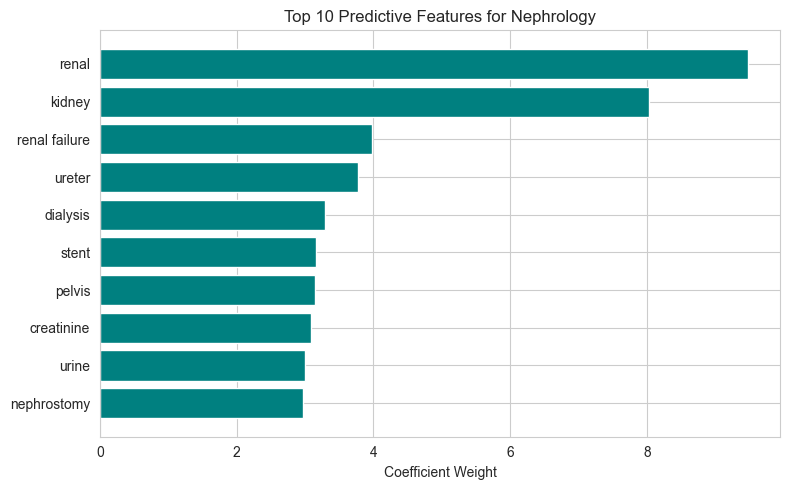

In [21]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = final_model.coef_
class_names_model = final_model.classes_

n_top = 10  # top features to show

for idx, specialty in enumerate(class_names_model[:5]):  # show first 5 specialties
    class_coef = coefficients[idx]
    top_idx = class_coef.argsort()[-n_top:][::-1]
    top_features = feature_names[top_idx]
    top_weights = class_coef[top_idx]

    plt.figure(figsize=(8, 5))
    bars = plt.barh(top_features[::-1], top_weights[::-1], color="teal")
    plt.title(f"Top {n_top} Predictive Features for {specialty}")
    plt.xlabel("Coefficient Weight")
    plt.tight_layout()
    plt.show()

In [17]:
print("="*70)
print("REPORT SUMMARY - ALL KEY METRICS")
print("="*70)
print("\n1. TEST SET PERFORMANCE:")
print(f"   Accuracy: {test_accuracy:.4f}")
print(f"   Macro F1-Score: {test_f1_macro:.4f}")
print(f"\n2. BEST HYPERPARAMETERS:")
print(f"   C: {final_model.C}")
print(f"   Solver: {final_model.solver}")
print(f"\n3. TOP PERFORMING SPECIALTY:")
print(f"   [Look at classification report]")
print(f"\n4. BOTTOM PERFORMING SPECIALTY:")
print(f"   [Look at classification report]")
print("="*70)

REPORT SUMMARY - ALL KEY METRICS

1. TEST SET PERFORMANCE:
   Accuracy: 0.7757
   Macro F1-Score: 0.6768

2. BEST HYPERPARAMETERS:
   C: 100.0
   Solver: lbfgs

3. TOP PERFORMING SPECIALTY:
   [Look at classification report]

4. BOTTOM PERFORMING SPECIALTY:
   [Look at classification report]
